# Self-supervised learning

We will learn how to work with CLIP and the main components of it.

**Put the kernel on GPU mode!**


In [ ]:
!pip install timm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
ERROR: Operation cancelled by user
ERROR: Operation cancelled by user


In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

#### Pseudo-code


In [ ]:
# image_encoder - ResNet or Vision Transformer
# text_encoder - CBOW or Text Transformer
# I[n, h, w, c] - minibatch of aligned images
# T[n, l] - minibatch of aligned texts
# W_i[d_i, d_e] - learned proj of image to embed
# W_t[d_t, d_e] - learned proj of text to embed
# t - learned temperature parameter
# extract feature representations of each modality
I_f = image_encoder(I) #[n, d_i]
T_f = text_encoder(T) #[n, d_t]
# joint multimodal embedding [n, d_e]
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)
# scaled pairwise cosine similarities [n, n]
logits = np.dot(I_e, T_e.T) * np.exp(t)
# symmetric loss function
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2

## Dataset preparation


In [ ]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = "XXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXX"

### For Flickr 8k
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip
dataset = "8k"


### For Flickr 30k
# !kaggle datasets download -d hsankesara/flickr-image-dataset
# !unzip flickr-image-dataset.zip
# dataset = "30k"

## Some pre-preocessing

In [ ]:
if dataset == "8k":
  df = pd.read_csv("captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
  df.to_csv("captions.csv", index=False)
  df = pd.read_csv("captions.csv")
  image_path = "/content/Images"
  captions_path = "/content"
elif dataset == "30k":
  df = pd.read_csv("/content/flickr30k_images/results.csv", delimiter="|")
  df.columns = ['image', 'caption_number', 'caption']
  df['caption'] = df['caption'].str.lstrip()
  df['caption_number'] = df['caption_number'].str.lstrip()
  df.loc[19999, 'caption_number'] = "4"
  df.loc[19999, 'caption'] = "A dog runs across the grass ."
  ids = [id_ for id_ in range(len(df) // 5) for _ in range(5)]
  df['id'] = ids
  df.to_csv("captions.csv", index=False)
  image_path = "/content/flickr30k_images/flickr30k_images"
  captions_path = "/content"

df.head()

,image,caption,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0


In [ ]:
class CFG:     ### config
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

## Utils

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

We need to encode both images and their describing texts. So, the dataset needs to **return both images and texts**.

We will use **DistilBERT** model from **HuggingFace** library as our text encoder; so, we need to **tokenize** the sentences (captions) with DistilBERT tokenizer and then feed the token ids (input_ids) and the attention masks to DistilBERT.

Therefore, the dataset needs to take care of the tokenization as well. Below you can see the dataset's code.

In the **\_\_init\_\_** we receive a tokenizer object which is actually a HuggingFace tokinzer; this tokenizer will be loaded when running the model. We are padding and truncating the captions to a specified max_length. In the **\_\_getitem\_\_** we will first load an encoded caption which is a dictionary with keys input_ids and attention_mask, make tensors out of its values and after that we will load the corresponding image, transform and augment it (if there is any!) and then we make it a tensor and put it in the dictionary with "image" as the key. Finally we put the raw text of the caption with the key "caption" in the dictionary only for visualization purposes.

I did not use additional data augmentations but you can add them if you want to improve the model's performance.

In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

The image encoder code is straight forward. Here we will use a ResNet50 as our image encoder.

The code encodes each image to a fixed size vector with the size of the model's output channels (in case of ResNet50 the vector size will be **2048**). This is the output after the nn.AdaptiveAvgPool2d() layer.

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

DistilBERT uses two special tokens that will be added to the actual input tokens: **CLS** and **SEP** which mark the start and end of a sentence.

To grab the whole representation of a sentence we use the final representations of the CLS token and we hope that this representation captures the overall meaning of the sentence (caption).

In the case of DistilBERT the output hidden representation for each token is a vector with size **768**. So, the whole caption will be encoded in the CLS token representation whose size is 768.

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

Now that we have encoded both our images and texts into fixed size vectors (2048 for image and 768 for text) we need to bring (project) them into a **new world** (!) with **similar dimensions** for both images and texts in order to be able to compare them and push apart the non-relevant image and texts and pull together those that match.

So, the following code will bring the 2048 and 768 dimensional vectors into a 256 (projection_dim) dimensional world, where we can **compare** them.

"embedding_dim" is the size of the input vector (2048 for images and 768 for texts) and "projection_dim" is the the size of the output vector which will be 256 for our case. For understanding the details of this part you can refer to the CLIP paper.

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

Here we will use the previous modules that we built to implement the main model.

- In the forward function, we first encode the images and texts separately into fixed size vectors (with different dimensionalities).

- After that, using separate projection modules we project them to that shared world (space). Here the encodings will become of similar shape (256).

- After that we will compute the loss.

To measure if two vectors are of similar characteristics (they are like each other) is to calculate their **dot product** (multiplying the matching entries and take the sum of them); if the final number is big, they are alike and if it is small they are not (relatively speaking)!

We have image_embeddings, a matrix with shape (batch_size, 256) and text_embeddings with shape (batch_size, 256).

We get a matrix with shape (batch_size, batch_size) which we will call logits. (temperature is equal to 1.0 in our case, so, it does not make a difference. You can play with it and see what difference it makes.)

Now that we have our logits, we need targets.

Let's consider what we hope that this model learns: **we want it to learn "similar representations (vectors)" for a given image and the caption describing it. Meaning that either we give it an image or the text describing it, we want it to produce same 256 sized vectors for both.**

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

So, in the best case scenario, text_embeddings and image_embedding matricies should be the same because they are describing similar things. Let's think now: if this happens, what would the logits matrix be like? Let's see with a simple example!

In [ ]:
# A simple Example

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


So logits, in the best case, will be a matrix that if we take its softmax - an identity matrix.

Now that we've got our targets matrix, we will use simple cross entropy to calculate the actual loss. I've written the full matrix form of cross entropy as a function which you can see in the bottom of the code block

### Let's talk a little bit more about loss function

https://towardsdatascience.com/clip-model-and-the-importance-of-multimodal-embeddings-1c8f6b13bf72

#### Cosine Similarities:

In [ ]:
logits = np.dot(I_e, T_e.T) * np.exp(t)
# Computes pairwise cosine similarities between image and text embeddings, scaled by a learned temperature parameter t.

logits = T_e @ T_e.T
# In this example, we interchangeably use similarity with logits in the same way that was used
#  in the original paper. We will not include the temperature parameter t in this blog post

#### Symmetric Loss Function:


CLIP uses contrastive loss (first introduced in Representation Learning with Contrastive Predictive Coding) to bring related images and texts closer together while pushing unrelated ones apart.

- labels = np.arange(n): Generates labels representing the indices of the batch.

- loss_i = cross_entropy_loss(logits, labels, axis=0): Computes the cross-entropy loss along the image axis.

- loss_t = cross_entropy_loss(logits, labels, axis=1): Computes the cross-entropy loss along the text axis.

- loss = (loss_i + loss_t)/2: Computes the symmetric average of the image and text losses.

In [ ]:
import torch
import torch.nn.functional as F

def CLIP_loss(logits: torch.Tensor) -> torch.Tensor:
    n = logits.shape[1]      # number of samples
    labels = torch.arange(n) # Create labels tensor

    # Calculate cross entropy losses along axis 0 and 1
    loss_i = F.cross_entropy(logits.transpose(0, 1), labels, reduction="mean")
    loss_t = F.cross_entropy(logits, labels, reduction="mean")
    # Calculate the final loss
    loss = (loss_i + loss_t) / 2

    return loss

In [ ]:
similarity_matrix = torch.rand(3, 3)  #  caption_embed @ image_embed.T
print(similarity_matrix)
print('Loss score: ', CLIP_loss(similarity_matrix))

tensor([[0.0703, 0.4107, 0.8197],
        [0.3398, 0.4761, 0.5429],
        [0.3250, 0.8825, 0.8637]])
Loss score:  tensor(1.1745)


## Train

Here are some funtions to help us load train and valid dataloaders, our model and then train and evaluate our model on those. There's not much going on here; just simple training loop and utility functions

In [ ]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the optimizer and lr_scheduler.

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 8 minutes on GPU if you are using 8k version (even one epoch is enough!). It can take some seconds before training actually starts because we are going to encode all the captions once in the train and valid dataset, so please don't stop it! Every thing is working fine.

In [ ]:
main()

## Inference

We will be giving the model a piece of text and want it to retrieve the most relevant images from an unseen validation (or test) set.

### Getting Image Embeddings

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [ ]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [ ]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

  0%|          | 0/253 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


### Finding Matches

This function does the final task that we wished our model would be capable of: it gets the model, image_embeddings, and a text query. It will display the most relevant images from the validation set.

In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

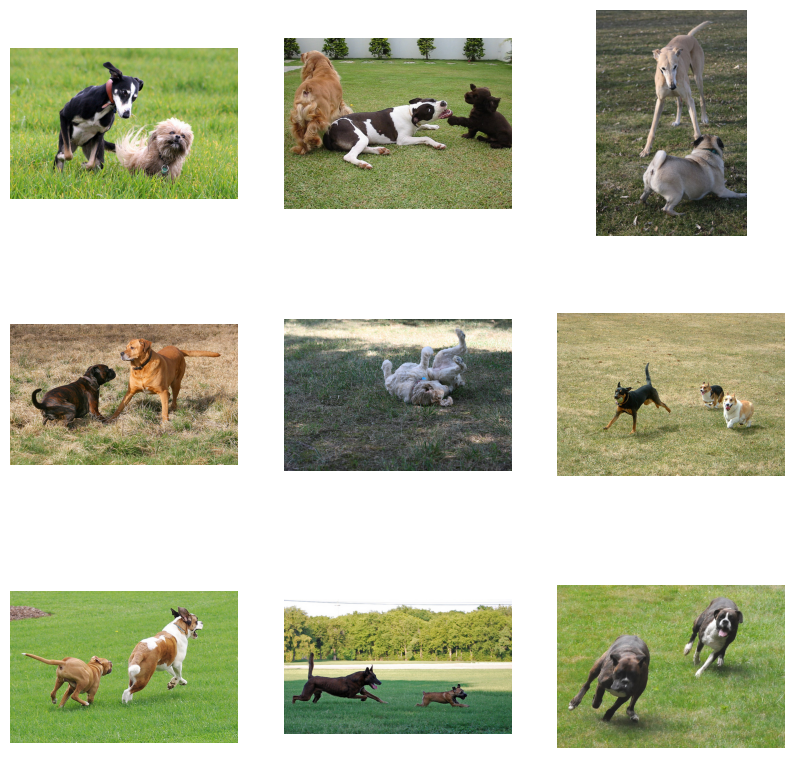

In [ ]:
find_matches(model,
             image_embeddings,
            #  query="dogs in the pool",
            #  query="dogs on the snow",
             query="dogs on the grass",
            #  query="a dog drinks water",
             image_filenames=valid_df['image'].values,
             n=9)

# References

1. https://towardsdatascience.com/simple-implementation-of-openai-clip-model-a-tutorial-ace6ff01d9f2
2. https://github.com/Kaushalya/medclip
3. https://github.com/RyanWangZf/MedCLIP
4. https://huggingface.co/docs/transformers/model_doc/clip

# Advanced. MedCLIP

https://github.com/RyanWangZf/MedCLIP

https://github.com/Kaushalya/medclip

In [ ]:
!pip install git+https://github.com/RyanWangZf/MedCLIP.git

  Cloning https://github.com/RyanWangZf/MedCLIP.git to /tmp/pip-req-build-55vu3n7r
  Running command git clone --filter=blob:none --quiet https://github.com/RyanWangZf/MedCLIP.git /tmp/pip-req-build-55vu3n7r
  Resolved https://github.com/RyanWangZf/MedCLIP.git to commit 9c3396f20d5d54e4fae241b8cb06ca45848e98c9
  Preparing metadata (setup.py) ... done


### 1. Vision and text encoders that extracts embeddings

 Here we get pretrained MedCLIP models

In [ ]:
from medclip import MedCLIPModel, MedCLIPVisionModelViT, MedCLIPVisionModel

# load MedCLIP-ResNet50
model = MedCLIPModel(vision_cls=MedCLIPVisionModel)
model.from_pretrained()

# load MedCLIP-ViT
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when in

load model weight from: ./pretrained/medclip-resnet


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT 

load model weight from: ./pretrained/medclip-vit


Load our test image

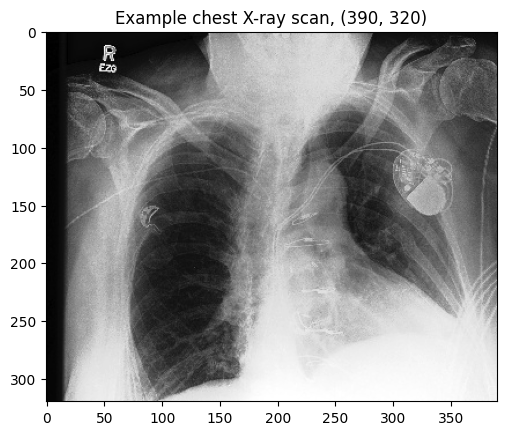

In [ ]:
from medclip import MedCLIPModel, MedCLIPVisionModelViT
from medclip import MedCLIPProcessor
from PIL import Image

# prepare for the demo image and texts
processor = MedCLIPProcessor()
image = Image.open('/view1_frontal.jpg')

import matplotlib.pyplot as plt

plt.imshow(image, cmap=plt.cm.gray)
plt.title(f'Example chest X-ray scan, {image.size}')   # width, height
plt.show()

In [ ]:
inputs = processor(
    text=["lungs remain severely hyperinflated with upper lobe emphysema",
        "opacity left costophrenic angle is new since prior exam ___ represent some loculated fluid cavitation unlikely"],
    images=image,
    return_tensors="pt",
    padding=True
    )

# pass to MedCLIP model
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.cuda()
outputs = model(**inputs)
print(outputs.keys())

# dict_keys(['img_embeds', 'text_embeds', 'logits', 'loss_value', 'logits_per_text'])

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'c

load model weight from: ./pretrained/medclip-vit
dict_keys(['img_embeds', 'text_embeds', 'logits', 'loss_value', 'logits_per_text'])


In [ ]:
outputs['text_embeds'].shape, outputs['img_embeds'].shape

(torch.Size([2, 512]), torch.Size([1, 512]))

In [ ]:
outputs['logits']

(tensor([[0.1729, 0.3899]], device='cuda:0', grad_fn=<TBackward0>),
 tensor([[0.1729],
         [0.3899]], device='cuda:0', grad_fn=<TBackward0>))

#### MedCLIP for Prompt-based Classification:

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'c

load model weight from: ./pretrained/medclip-vit


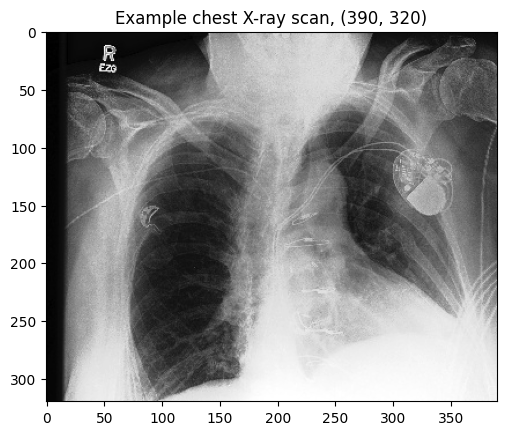

In [ ]:
from medclip import MedCLIPModel, MedCLIPVisionModelViT
from medclip import MedCLIPProcessor
from medclip import PromptClassifier

processor = MedCLIPProcessor()
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
clf = PromptClassifier(model, ensemble=True)
clf.cuda()

# prepare input image
from PIL import Image
image = Image.open('/view1_frontal.jpg')
inputs = processor(images=image, return_tensors="pt")

import matplotlib.pyplot as plt
plt.imshow(image, cmap=plt.cm.gray)
plt.title(f'Example chest X-ray scan, {image.size}')   # width, height
plt.show()

In [ ]:
# prepare input prompt texts
from medclip.prompts import generate_chexpert_class_prompts, process_class_prompts
cls_prompts = process_class_prompts(generate_chexpert_class_prompts(n=10))
inputs['prompt_inputs'] = cls_prompts

sample 10 num of prompts for Atelectasis from total 210
sample 10 num of prompts for Cardiomegaly from total 15
sample 10 num of prompts for Consolidation from total 192
sample 10 num of prompts for Edema from total 18
sample 10 num of prompts for Pleural Effusion from total 54


In [ ]:
cls_prompts['Atelectasis'].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# make classification
output = clf(**inputs)
print(output['class_names'])
print(output['logits'])

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
tensor([[0.3568, 0.4737, 0.1614, 0.2428, 0.3855]], device='cuda:0',
       grad_fn=<StackBackward0>)


## Try with other datasets

 ### MIMIC-CXR

 https://huggingface.co/datasets/hongrui/mimic_chest_xray_v_1

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("hongrui/mimic_chest_xray_v_1")  #

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text', 'report'],
        num_rows: 89395
    })
})

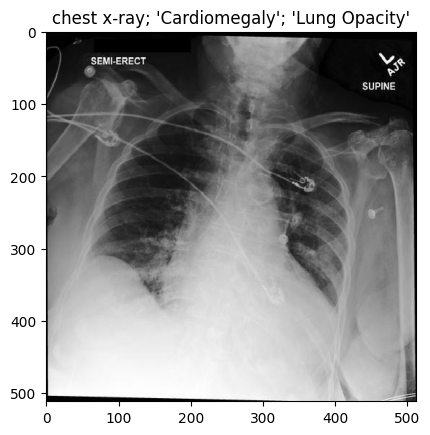

Lung volumes are low. Retrocardiac opacity with silhouetting of the left hemidiaphragm and lateral border of the descending aorta is nonspecific and could reflect any of a combination of atelectasis, focal pneumonia or even a small effusion. Right infrahilar opacity with slight indistinctness of the right heart border could reflect infection in the appropriate clinical scenario. Apparent elevation of the right hemidiaphragm may be related to positioning and technique versus volume loss. There is cardiomegaly, but no CHF. Aortic calcifications are present. No pneumothorax.


In [ ]:
img = ds['train'][0]['image']
labels = ds['train'][0]['text']
report = ds['train'][0]['report']

plt.imshow(img)
plt.title(labels)
plt.show()

print(report)

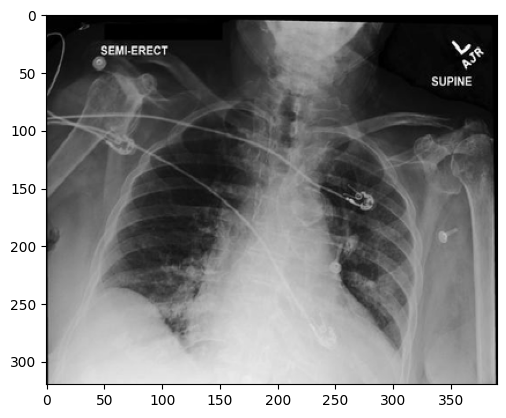

In [ ]:
# reshape to correct size (w:390, h: 320)
nimg = img
size = 390, 390
nimg.thumbnail(size, Image.Resampling.LANCZOS)
nimg = nimg.crop((0, 0, 390, 320))

plt.imshow(nimg)
plt.show()

In [ ]:
inputs = processor(
    text=["lungs remain severely hyperinflated with upper lobe emphysema",
          "it is a dog playing in grass",
        "Lung volumes are low. Retrocardiac opacity with silhouetting of the left hemidiaphragm and lateral border of the descending aorta is nonspecific and could reflect any of a combination of atelectasis, focal pneumonia or even a small effusion. Right infrahilar opacity with slight indistinctness of the right heart border could reflect infection in the appropriate clinical scenario. Apparent elevation of the right hemidiaphragm may be related to positioning and technique versus volume loss. There is cardiomegaly, but no CHF. Aortic calcifications are present. No pneumothorax."],
    images=nimg,
    return_tensors="pt",
    padding=True
    )

# pass to MedCLIP model
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained()
model.cuda()
outputs = model(**inputs)
print(outputs.keys())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializ

load model weight from: ./pretrained/medclip-vit
dict_keys(['img_embeds', 'text_embeds', 'logits', 'loss_value', 'logits_per_text'])


In [ ]:
outputs['logits'], outputs['loss_value']

(tensor([[0.1703, 0.0973, 0.0868]], device='cuda:0', grad_fn=<TBackward0>),
 None)

### Pneumonia Classification

https://huggingface.co/datasets/keremberke/chest-xray-classification

In [ ]:
from datasets import load_dataset

ds = load_dataset("keremberke/chest-xray-classification", name="full")
example = ds['train'][0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4077 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1165 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/582 [00:00<?, ? examples/s]

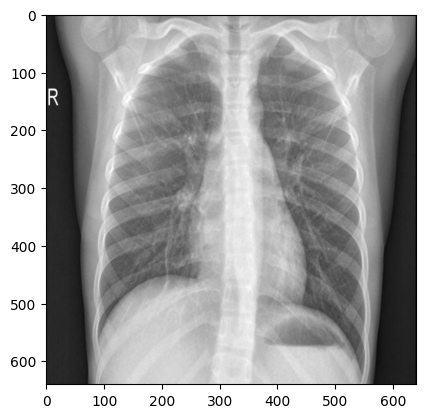

(640, 640)


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

example = ds['train'][0]
plt.imshow(example['image'])
plt.show()
print(example['image'].size)

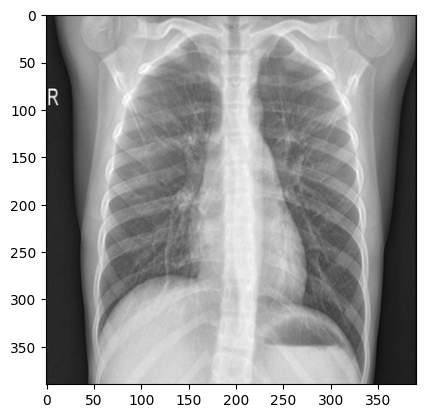

In [ ]:
# reshape to (w: 390, h: 320)
nimg = example['image']
size = 390, 390
nimg.thumbnail(size, Image.Resampling.LANCZOS)
nimg = nimg.crop((0, 0, 390, 320))

plt.imshow(nimg)
plt.show()

#### You can try to predict this class and fine-tune CLIP to predict

In [ ]:
inputs = processor(images=nimg, return_tensors="pt")
# prepare input prompt texts
from medclip.prompts import generate_class_prompts
cls_prompts = process_class_prompts(generate_class_prompts(...))
inputs['prompt_inputs'] = cls_prompts

# make classification
output = clf(**inputs)
print(output['class_names'])
print(output['logits'])